In [1]:
import numpy as np
import igraph as ig
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

import itertools
from scipy.stats import spearmanr

from pathlib import Path

import os
import sys  

# set path for pixelator directory 
sys.path.insert(0, "/Users/janrkauert/pixelator/")

# load functions from pixelator
from pixelator.pixeldataset import PixelDataset
from pixelator.graph import Graph

# load standard workflow single cell functions
from colocalization_measures.plot import plot_mutliple_markers
from colocalization_measures.higher_order_similarity import calculate_higher_order_similarity
from colocalization_measures.adjusted_local_assortativity import calculate_adjusted_local_assorativity
from colocalization_measures.colocalization_scores import create_colocalization_scores, create_higher_order_similarity_df

# get directory with graph eval files
path_name = "C:/Users/janrh/Downloads/Pixelator_data"

In [13]:
# remove performance warning from dataframes
import warnings
warnings.filterwarnings('ignore')

Create mockup explaining local assortativity based on the degree of the graph

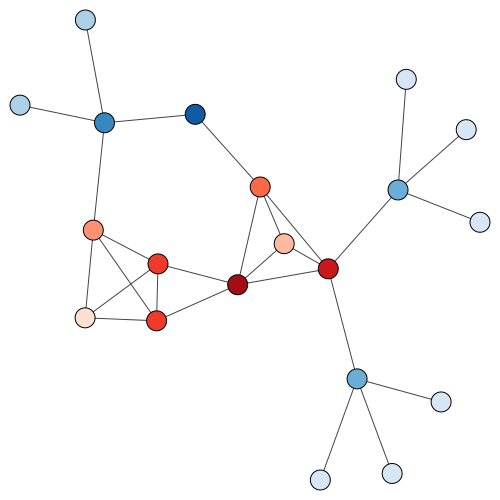

In [2]:
# create mockup graph
mock_up_assort = ig.Graph()
mock_up_assort.add_vertices(list(range(20)))

mock_up_assort.add_edges([(0, 1), (0, 2), (0,3), (0,4)])
mock_up_assort.add_edges([(15, 12), (15, 13), (15, 14), (15, 10)])
mock_up_assort.add_edges([(19, 16), (19, 17), (19, 18), (19, 4)])

mock_up_assort.add_edges([(5, 8)])
mock_up_assort.add_edges([(5, 11)])
mock_up_assort.add_edges([(6, 14)])

mock_up_assort.add_edges([(4, 7), (5,7), (6, 7), (4, 5), (5, 6), (6, 4)])
mock_up_assort.add_edges([(8, 11), (9, 11), (10, 11), (8, 9), (9, 10), (10, 8)])

# get assortativity scores after normalization
loc_rounded = calculate_adjusted_local_assorativity(mock_up_assort, mock_up_assort.degree())
loc_rounded = [np.round(score, 2) for score in loc_rounded]

# get color pallet with seaborn
positive_scores = [score for score in loc_rounded if score > 0]
negative_scores = [score for score in loc_rounded if score < 0]

# create dictionaries for the coloring
color_dict_pos = dict(zip(sorted(list(set(positive_scores))), sns.color_palette("Reds", n_colors=len(list(set(positive_scores)))))) 
color_dict_neg = dict(zip(sorted(list(set(negative_scores))), sns.color_palette("Blues", n_colors=len(list(set(negative_scores)))))) 
color_dict_zero = dict(zip([0], ["white"]))

# color vertices
color_dict = color_dict_pos | color_dict_neg | color_dict_zero         
colors_vertices = [color_dict[num] for num in loc_rounded]

# get mean of the assortativity scores
mean_loc = np.mean(positive_scores)

# plot mockup
ig.plot(mock_up_assort, vertex_color=colors_vertices, bbox=(500,500))

Load Uropod data and control sample

In [3]:
sample_list = []
pxl_data_list = []

for index_place, file in enumerate(sorted(os.listdir(path_name))):
    
    # get name of current file in directory
    filename = os.fsdecode(file)

    # load marker edge list
    pxl_data = PixelDataset.from_file(path_name + "/" + filename)
    edge_list_df = pxl_data.edgelist   

    edge_list_df.columns = [col.lower() for col in edge_list_df.columns]

    # build the graph
    graph = Graph.from_edgelist(edgelist=edge_list_df,
                                add_marker_counts=True,
                                simplify=False,
                                use_full_bipartite=False)
    mega_graph = graph._raw
    
    # add filename as a vertex attribute
    mega_graph.es["sample"] = [filename] * mega_graph.ecount()

    sample_list.append(mega_graph)
    pxl_data_list.append(pxl_data)

    print(filename)

Edge list with no sequence found


Uropod_S1_001.dataset.pxl


Edge list with no sequence found


Uropod_S3_001.dataset.pxl


In [4]:
# select sample to work on
sample_index = 1
marker = "CD50"

# create component dict
comp_dict = dict(zip(pxl_data_list[sample_index].edgelist["upia"].values.tolist(), pxl_data_list[sample_index].edgelist["component"].values.tolist()))

# subgraphs of the selected sample
graph_component_subgraphs = sample_list[sample_index].components().subgraphs()

# add component name
for comp in graph_component_subgraphs:
    comp.vs["component"] = comp_dict[comp.vs[0]["name"]]

# get polarization scores for the selected marker
pol_df = pxl_data_list[sample_index].polarization
pol_df = pol_df.loc[pol_df['marker'] == marker]

# get ten most polarized components names
pol_components = pol_df.sort_values(by="morans_i", ascending=False)["component"][:200].values.tolist()
pol_components = set(pol_components)

# get the subgraphs belonging to the selected component names
top_polarised_components = [comp for comp in graph_component_subgraphs if comp_dict[comp.vs[0]["name"]] in pol_components and comp.vcount() > 1000 and comp.vcount() < 3000]

Plot marker counts for mutliple markers on the same component

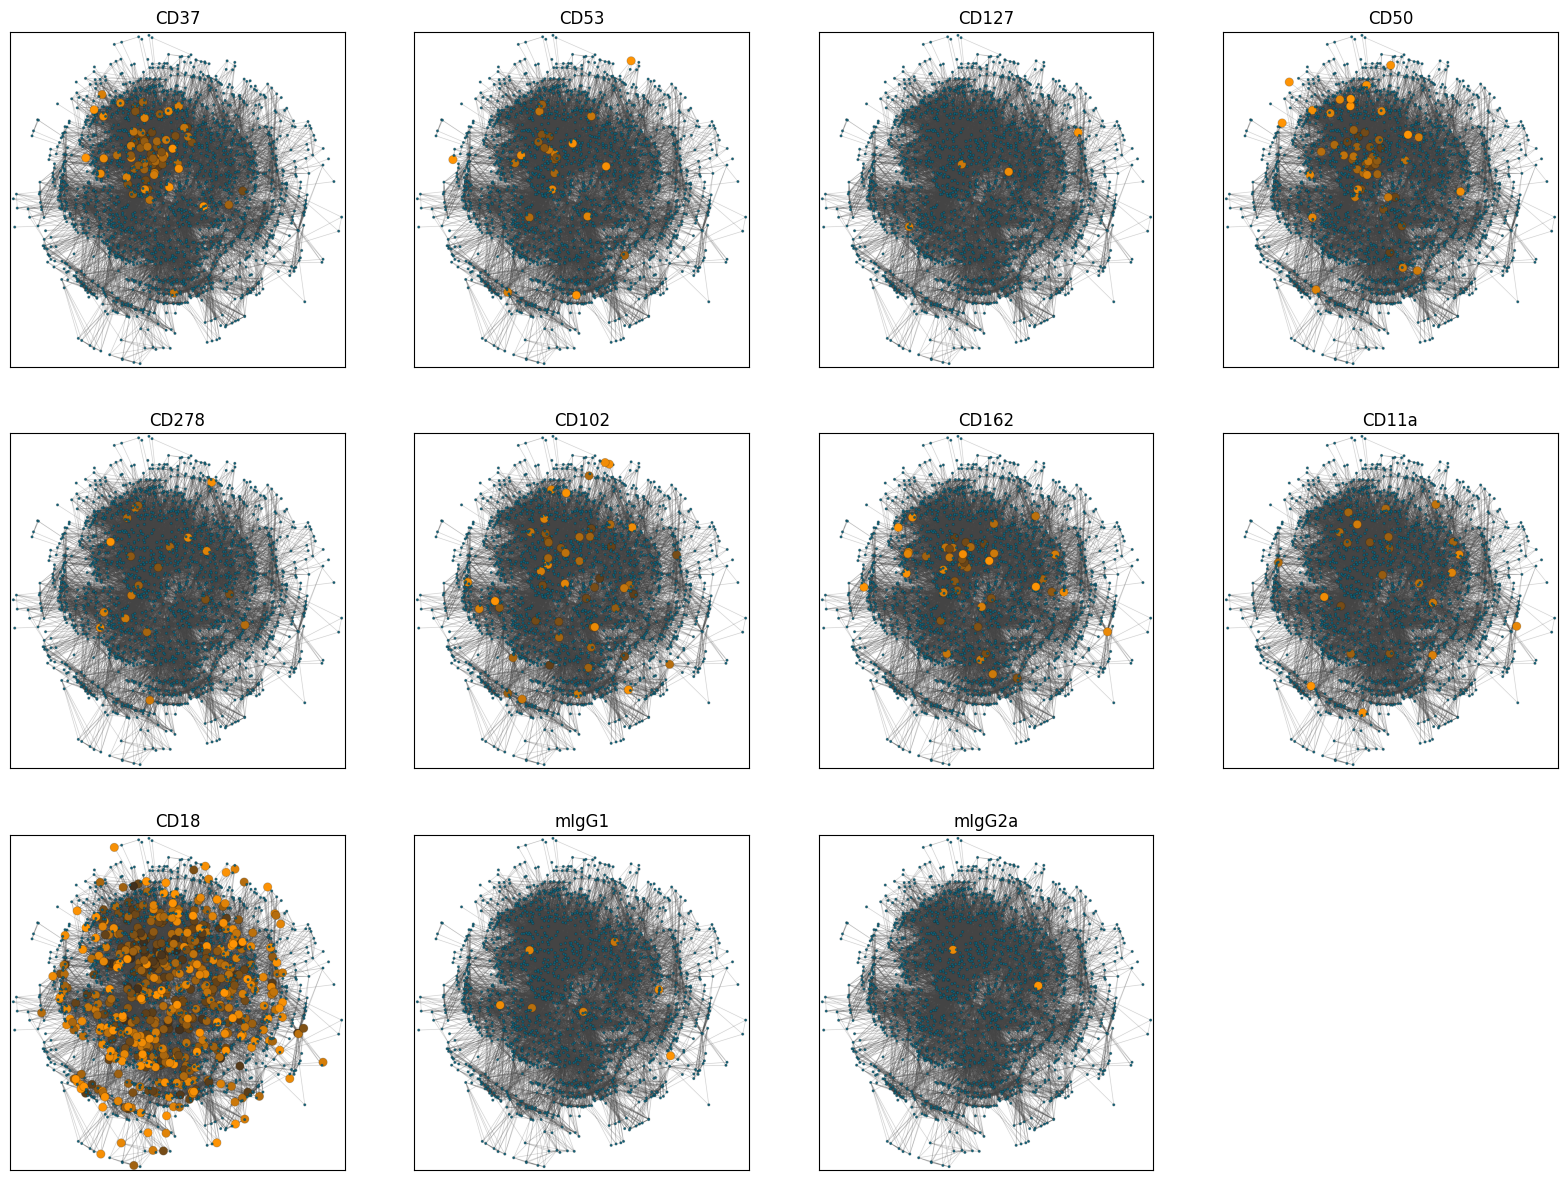

In [14]:
plot_mutliple_markers(top_polarised_components[8], ["CD37", "CD53", "CD127", "CD50", "CD278", "CD102", "CD162", "CD11a", "CD18","mIgG1", "mIgG2a"], False)

Plot adjusted local assorativity for multiple markers on the same component

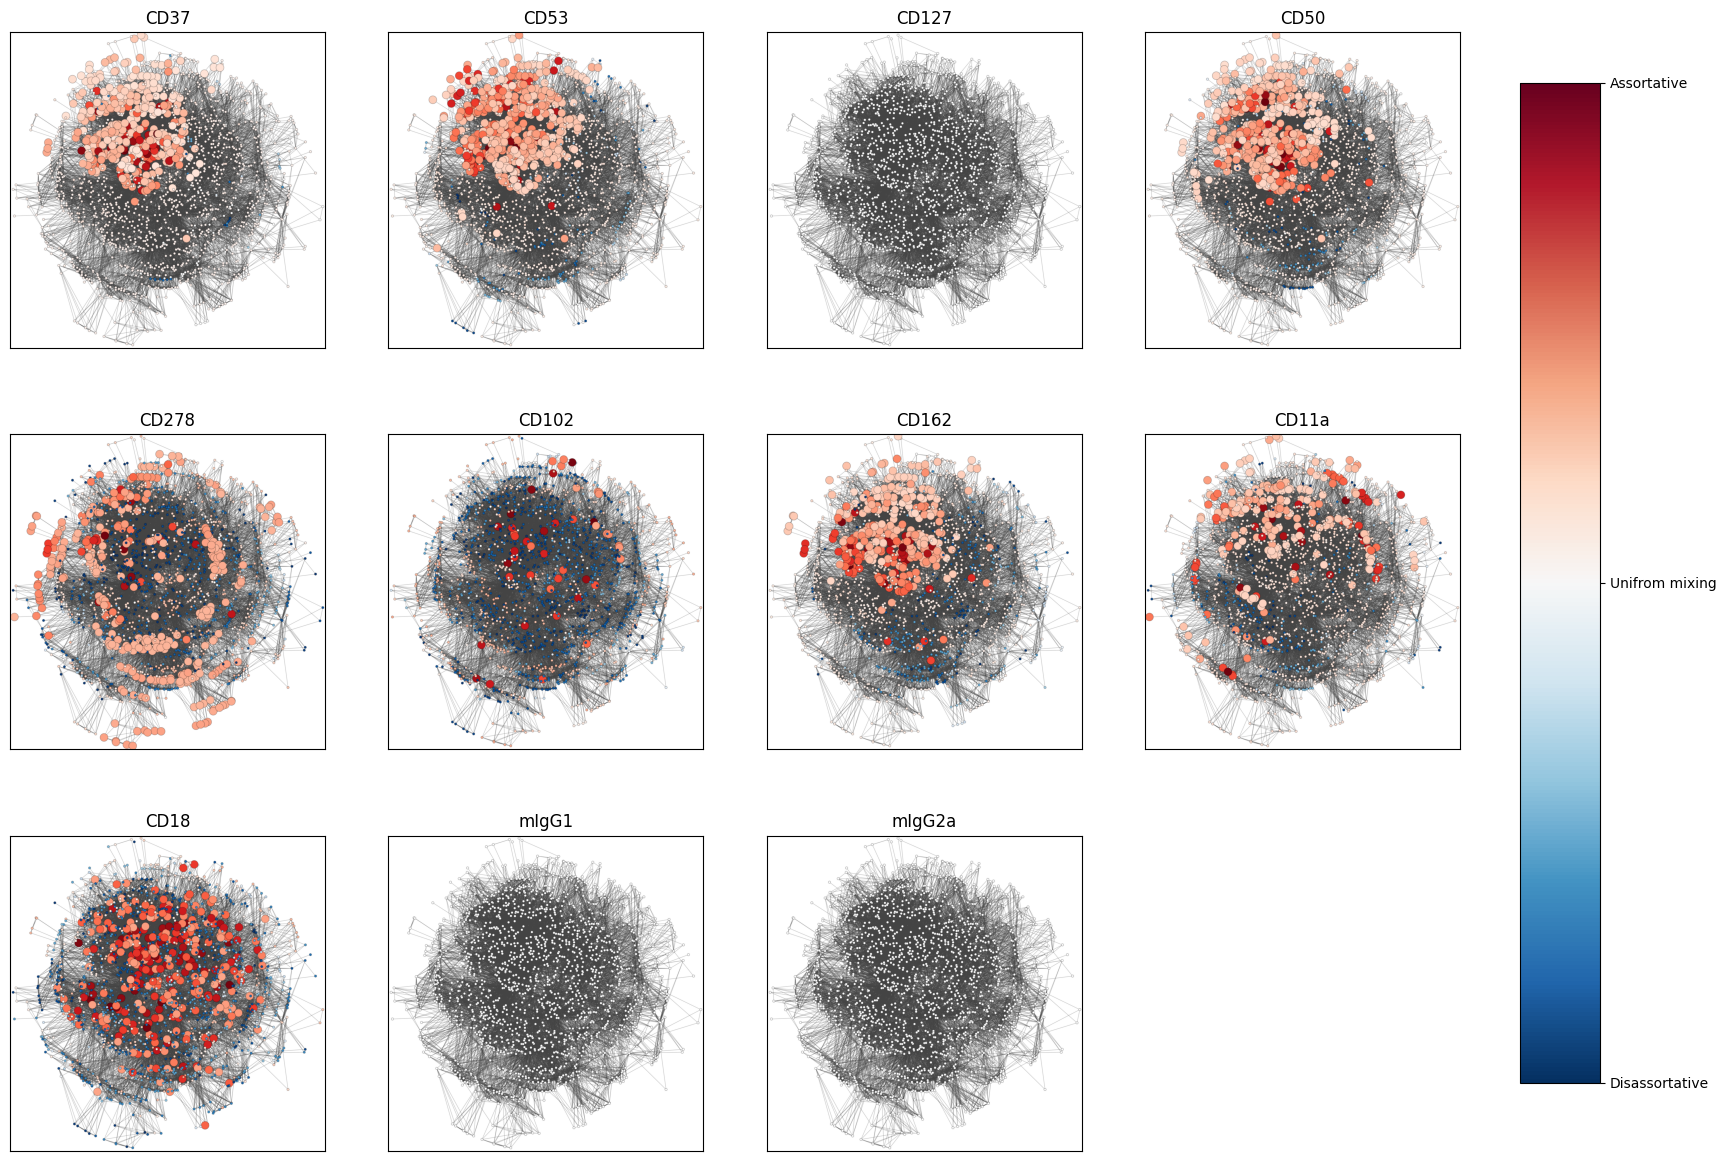

In [15]:
plot_mutliple_markers(top_polarised_components[8], ["CD37", "CD53", "CD127", "CD50", "CD278", "CD102", "CD162", "CD11a", "CD18","mIgG1", "mIgG2a"], True)

Plot distribution local assorativity values before transofrming them

/Users/janrkauert/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


''

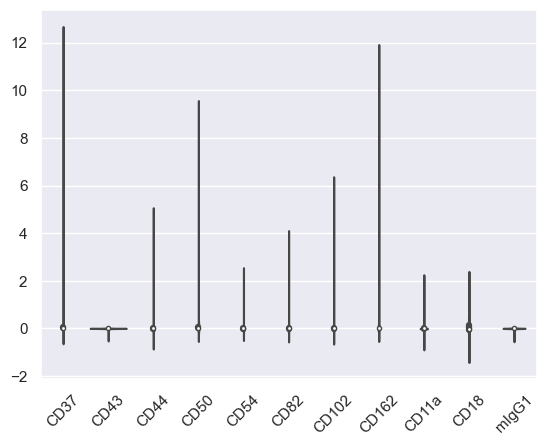

In [ ]:
from colocalization_measures.local_assortativity import localAssortF_numeric

sns.set_theme()
df_plot = pd.DataFrame()

for marker in ["CD37", "CD43", "CD44", "CD50", "CD54", "CD82", "CD102", "CD162", "CD11a", "CD18","mIgG1"]:
    marker_counts = [vertex["markers"][marker] for vertex in top_polarised_components[9].vs]
    loc_assort = localAssortF_numeric(top_polarised_components[9], marker_counts, True)

    loc_assort = [np.round(num, 2) for num in loc_assort]

    df_plot[marker] = loc_assort

# create subfigure
ax = sns.violinplot(data=df_plot)
plt.xticks(rotation=45)

plt.xlabel("Markers")
plt.ylabel("Local assorativity score")

Plot local assorativity values after transforming them (adjusted local assorativity)

/Users/janrkauert/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


''

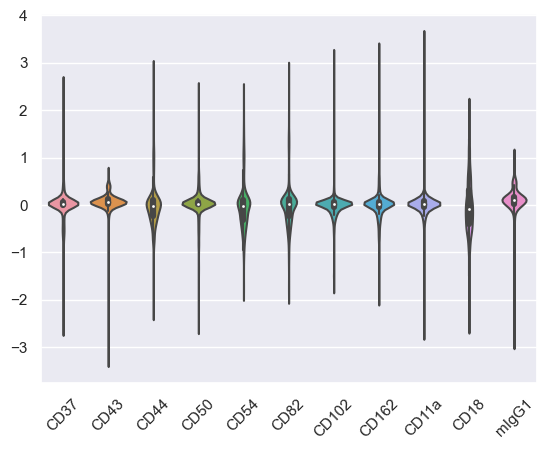

In [ ]:
sns.set_theme()
df_plot = pd.DataFrame()

for marker in ["CD37", "CD43", "CD44", "CD50", "CD54", "CD82", "CD102", "CD162", "CD11a", "CD18","mIgG1"]:
    adj_loc_assort = calculate_adjusted_local_assorativity(top_polarised_components[9], marker)
    adj_loc_assort = [np.round(num, 2) for num in adj_loc_assort]

    df_plot[marker] = adj_loc_assort

# create subfigure
ax = sns.violinplot(data=df_plot)
plt.xticks(rotation=45)

plt.xlabel("Markers")
plt.ylabel("Adjusted local assorativity score")

Plot adjusted local assorativity for a single component and a single marker

In [ ]:
def plot_single_marker(graph, marker):
    """
    Plot the adjusted local assortativity values for a single graph and a single marker.

    :param graph: A iGraph graph object with either the marker in graph.vs.att
    :param marker: The marker that should be plotted, either 
    """
    
    # get assortativity scores after normalization
    loc_rounded = calculate_adjusted_local_assorativity(graph, marker)
    loc_rounded = [np.round(score, 2) for score in loc_rounded]

    # get color pallet with seaborn
    positive_scores = [score for score in loc_rounded if score > 0]
    negative_scores = [score for score in loc_rounded if score < 0]

    # create dictionary for coloring the local assortivity
    color_dict_pos = dict(zip(sorted(list(set(positive_scores))), sns.color_palette("Reds", n_colors=len(list(set(positive_scores)))))) 
    color_dict_neg = dict(zip(sorted(list(set(negative_scores))), sns.color_palette("Blues", n_colors=len(list(set(negative_scores)))))) 
    color_dict_zero = dict(zip([0], ["white"]))

    # combine dictonaries
    color_dict = color_dict_pos | color_dict_neg | color_dict_zero
                    
    # color vertices
    if np.isnan(loc_rounded).any():
        colors_vertices = ["grey"] * graph.vcount()
    else:
        colors_vertices = [color_dict[num] for num in loc_rounded]

    # get mean of the assortativity scores
    mean_loc = np.mean(positive_scores)

    # define vertex sizes if score is above the mean
    size = [11 if loc > mean_loc else 6 for loc in loc_rounded]

    ig.plot(graph, vertex_size=size, vertex_color=colors_vertices, 
                    layout=graph.layout_kamada_kawai(), bbox=(500,500))

In [ ]:
graph = top_polarised_components[6]
marker = "CD50"

plot_single_marker(graph, marker)

Calculate pairwise colocalization scores

In [17]:
from upsetplot import UpSet

def create_upset_plot(marker_names, similarity_measure_df):
    # create new dataframe for the upset plot as this requires a specific type of structure
    upset_plot_df = pd.DataFrame()

    # iterate through all maker names to get boolean values if they are part of the current combination
    for marker in marker_names:
        # true or false values for each marker combination
        true_false_values = [marker in set(combination_name.split("_")) for combination_name in similarity_measure_df.index.values.tolist()]
        
        # add boolean values to dataframe
        upset_plot_df[marker] = true_false_values

    # combine scores with a chosen metric and save as scores (required by UpSet plot)
    upset_plot_df["scores"] = similarity_measure_df.mean(axis=1).values

    # set index to combination names
    upset_plot_df = upset_plot_df.set_index(marker_names)

    # plot upset diagram
    upset_plot = UpSet(upset_plot_df, sum_over="scores", sort_categories_by="input")

    return upset_plot

{'matrix': <AxesSubplot:>,
 'shading': <AxesSubplot:>,
 'totals': <AxesSubplot:>,
 'intersections': <AxesSubplot:ylabel='Intersection size'>}

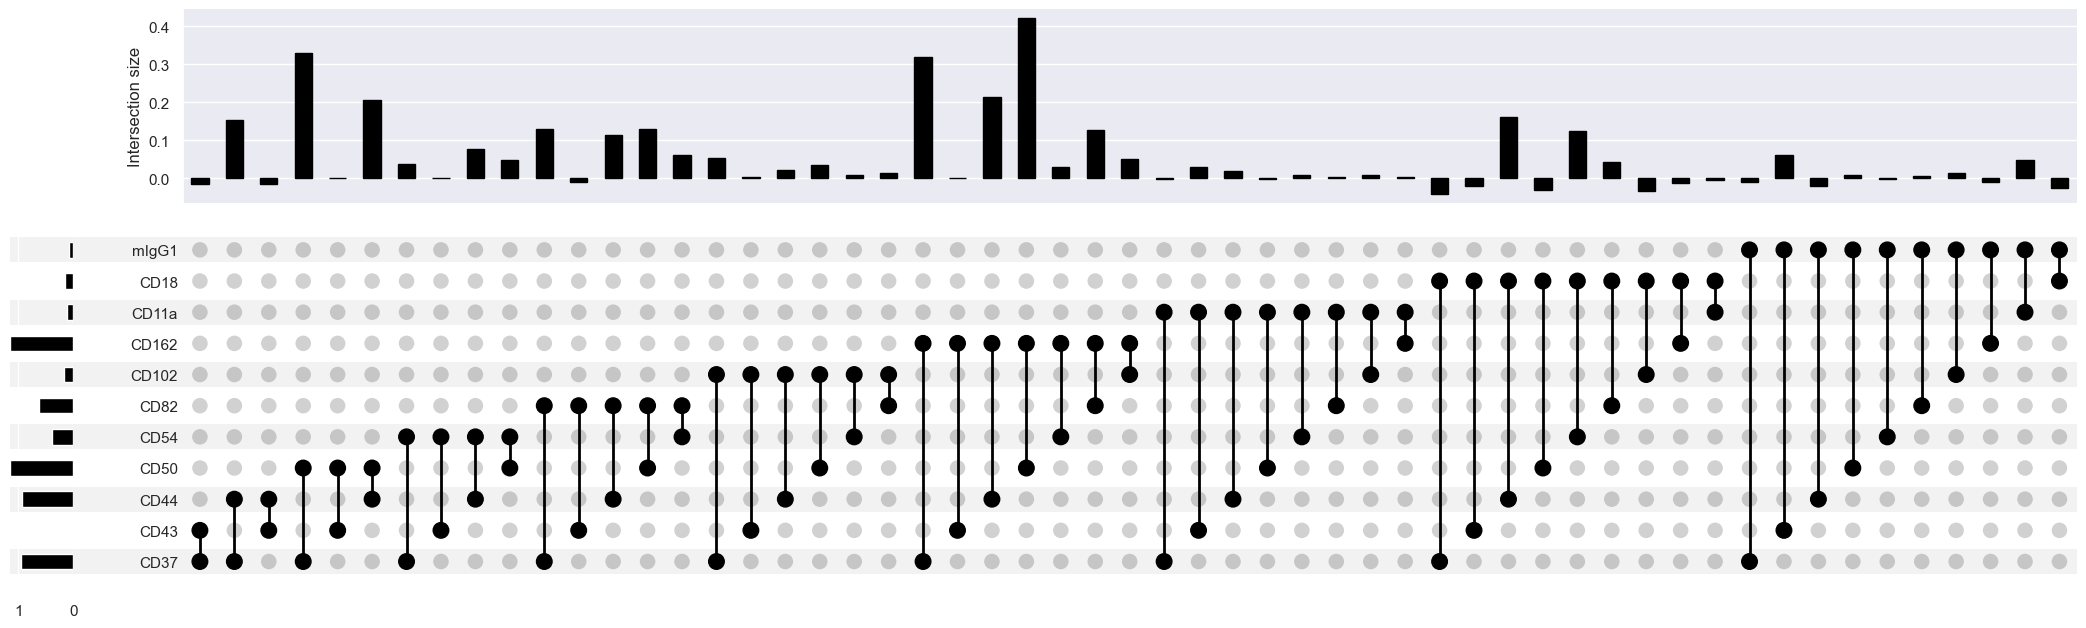

In [ ]:
marker_names = ["CD37", "CD43", "CD44", "CD50", "CD54", "CD82", "CD102", "CD162", "CD11a", "CD18","mIgG1"]
path_data = str(Path.cwd().parent) + "/code_paper/paper_data/S3"

# calculate pairwise colocalization scores
similarity_measure_df = create_colocalization_scores(marker_names, path_data)

# plot scores
create_upset_plot(marker_names, similarity_measure_df).plot()

In [ ]:
smlr_df = similarity_measure_df.mean(axis=1)

# create new dataframe to store the abundance of the markers per component
df_abundance = pd.DataFrame()
df_abundance["markers"] = marker_names


for comp_index, component in enumerate(top_polarised_components[:100]):

    list_abundace_comp = []
    for marker in marker_names:
        
        # get the total number of marker counts for each marker in the list
        abundance = [vertex["markers"][marker] for vertex in component.vs]
        list_abundace_comp.append(sum(abundance))

    df_abundance["comp_" + str(comp_index)] = list_abundace_comp
    
# set index dataframe and get mean abundance for each marker across all components
df_abundance = df_abundance.set_index("markers")
df_abundance = df_abundance.mean(axis=1)

/var/folders/t6/3j9dpsvn20g9cmwyxvs6b0mc0000gp/T/ipykernel_1559/3757047390.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_abundance["comp_" + str(comp_index)] = list_abundace_comp


In [ ]:
max_abundance = []
for marker_combination in smlr_df.index.values:

    # get marker names from the combinations in the similarity dataframe
    marker_0 = marker_combination.split("_")[0]
    marker_1 = marker_combination.split("_")[1]

    # get maximum abundance for the marker pair based on the abundance dataframe
    max_abundance.append(np.max([df_abundance[df_abundance.index == marker_0].values[0], 
                                 df_abundance[df_abundance.index == marker_1].values[0]]))

''

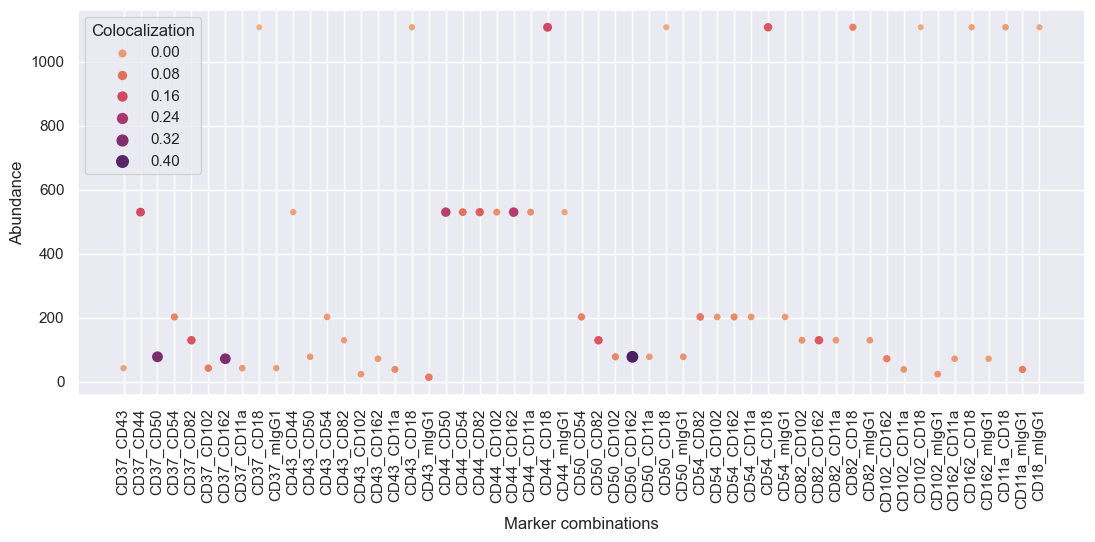

In [ ]:
# merge abundance DataFrame and similarity DataFrame
abundance_vs_smlr_df = pd.DataFrame({"markers": smlr_df.index.values, "Colocalization": smlr_df.values, "Abundance": max_abundance})
abundance_vs_smlr_df = abundance_vs_smlr_df.set_index("markers")

# create a scatter plot highlithing the correlation between abundance and pairwise colocalization
sns.set(rc={'figure.figsize':(13, 5)})
sns.scatterplot(x=abundance_vs_smlr_df.index.values, y=abundance_vs_smlr_df["Abundance"], 
                hue=abundance_vs_smlr_df["Colocalization"], palette="flare", size=abundance_vs_smlr_df["Colocalization"], linewidth=0)

plt.xlabel("Marker combinations")
plt.xticks(rotation=90)
;

Differential colocalization of order 2

{'matrix': <AxesSubplot:>,
 'shading': <AxesSubplot:>,
 'totals': <AxesSubplot:>,
 'intersections': <AxesSubplot:ylabel='Intersection size'>}

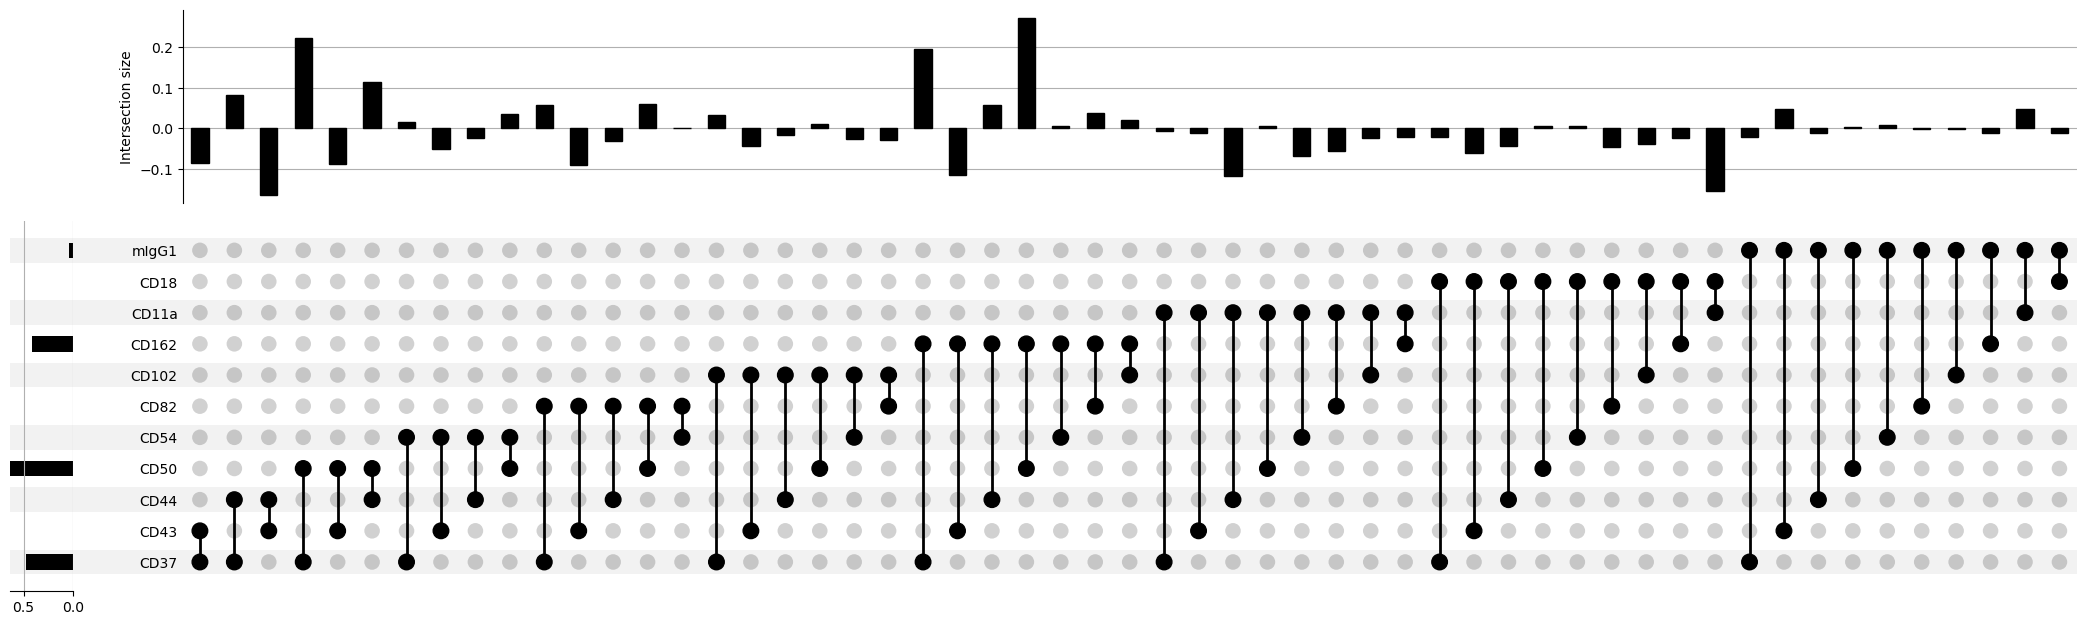

In [ ]:
marker_names = ["CD37", "CD43", "CD44", "CD50", "CD54", "CD82", "CD102", "CD162", "CD11a", "CD18","mIgG1"]
path_data_S1 = str(Path.cwd().parent) + "/code_paper/paper_data/S1"
path_data_S3 = str(Path.cwd().parent) + "/code_paper/paper_data/S3"

# calculate pairwise colocalization scores
similarity_measure_df_S1 = create_colocalization_scores(marker_names, path_data_S1)
similarity_measure_df_S3 = create_colocalization_scores(marker_names, path_data_S3)

similarity_measure_df = similarity_measure_df_S3.mean(axis=1) - similarity_measure_df_S1.mean(axis=1)
similarity_measure_df = pd.DataFrame(similarity_measure_df)

# plot scores
create_upset_plot(marker_names, similarity_measure_df).plot()

Higher order similarity order 3

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

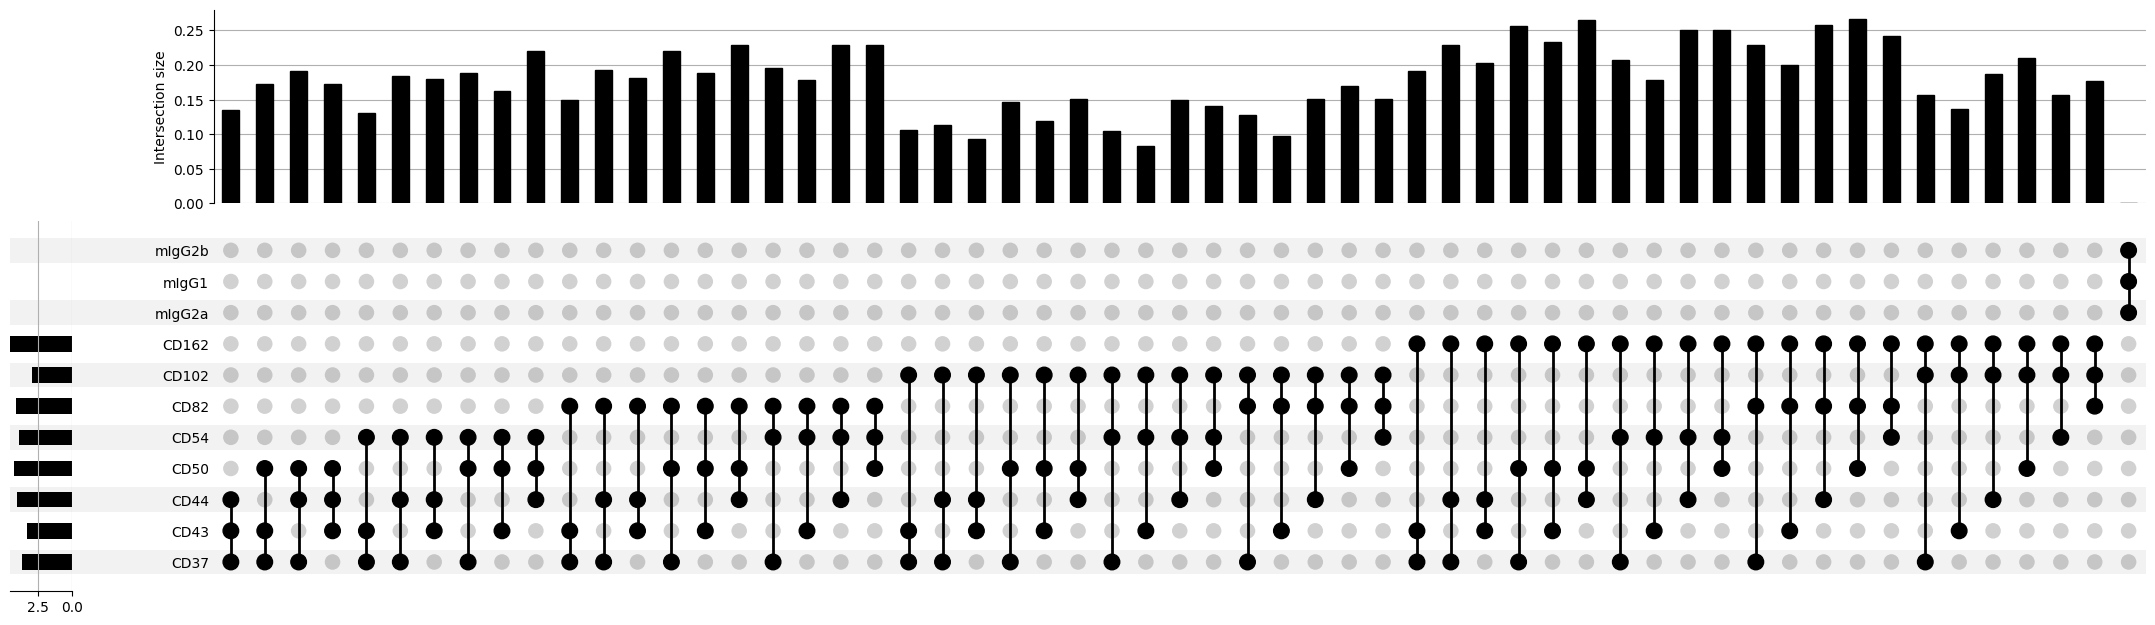

In [28]:
marker_names =  ["CD37", "CD43", "CD44", "CD50", "CD54", "CD82", "CD102", "CD162"]
path_data_S3 = "C:/Users/janrh/Documents/GitHub/TDA-local-assortativity-paper/S3"

# calculate pairwise colocalization scores
similarity_measure_df_S3 = create_higher_order_similarity_df(marker_names, path_data_S3, 3)

# plot scores
create_upset_plot(marker_names + ["mIgG2a", "mIgG1", "mIgG2b"], similarity_measure_df_S3).plot()

In [ ]:
marker_names = ["CD37", "CD43", "CD44", "CD50", "CD54", "CD82", "CD102", "CD162"]
path_data_S1 = "C:/Users/janrh/Documents/GitHub/TDA-local-assortativity-paper/S1"
path_data_S3 = "C:/Users/janrh/Documents/GitHub/TDA-local-assortativity-paper/S3"

# calculate pairwise colocalization scores
similarity_measure_df_S1 = create_higher_order_similarity_df(marker_names, path_data_S1, 3)
similarity_measure_df_S3 = create_higher_order_similarity_df(marker_names, path_data_S3, 3)

similarity_measure_df = similarity_measure_df_S3.mean(axis=1) - similarity_measure_df_S1.mean(axis=1)
similarity_measure_df = pd.DataFrame(similarity_measure_df)

# plot scores
create_upset_plot(marker_names, similarity_measure_df).plot()

Higher order similarity order 4

{'matrix': <AxesSubplot:>,
 'shading': <AxesSubplot:>,
 'totals': <AxesSubplot:>,
 'intersections': <AxesSubplot:ylabel='Intersection size'>}

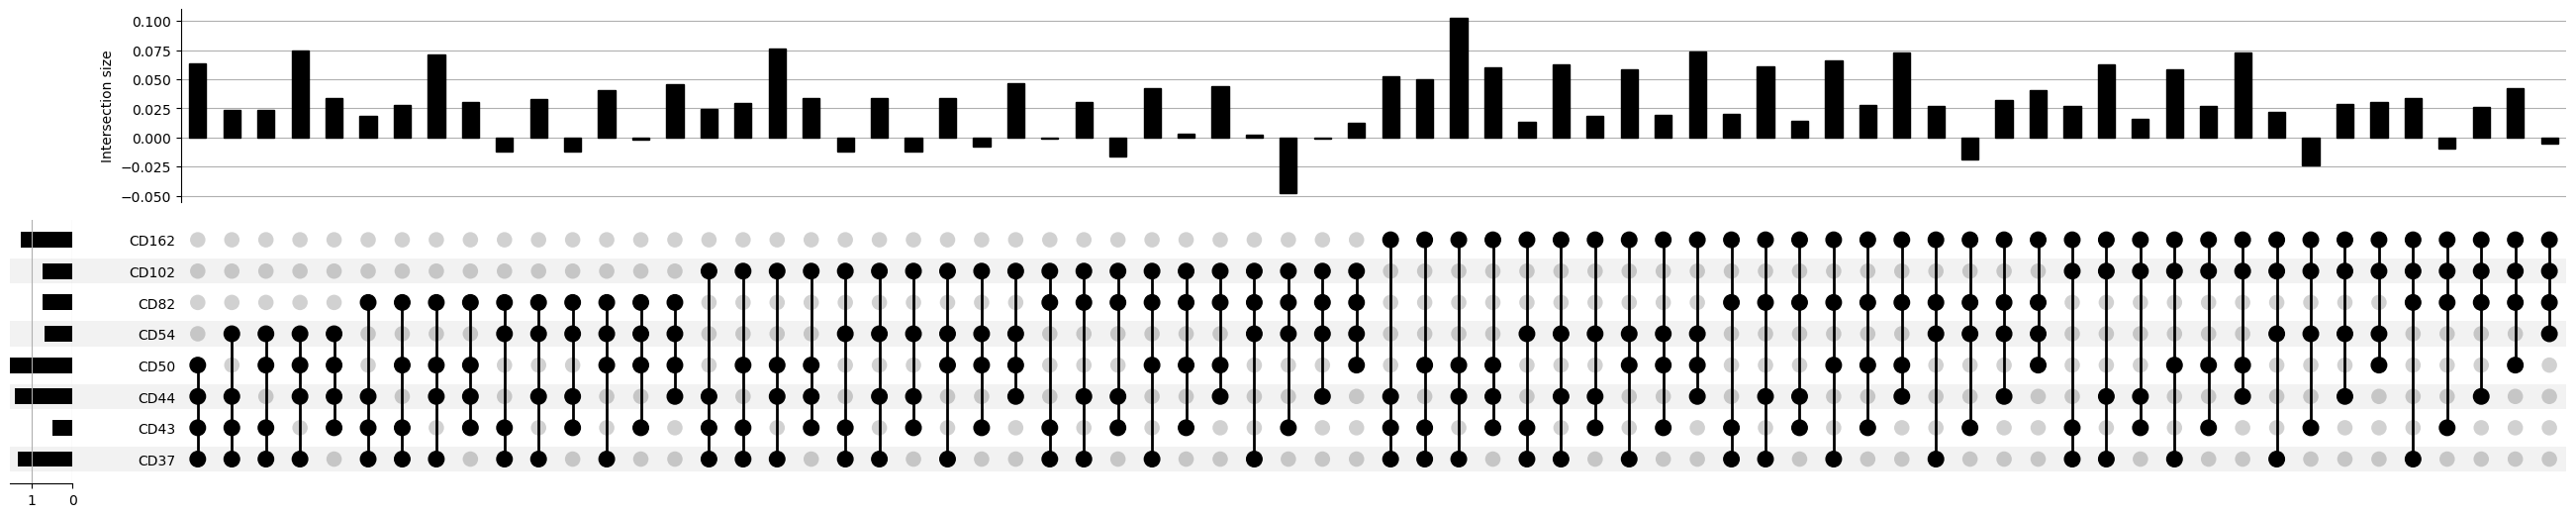

In [ ]:
marker_names = ["CD37", "CD43", "CD44", "CD50", "CD54", "CD82", "CD102", "CD162"]
path_data_S1 = str(Path.cwd().parent) + "/code_paper/paper_data/S1"
path_data_S3 = str(Path.cwd().parent) + "/code_paper/paper_data/S3"

# calculate pairwise colocalization scores
similarity_measure_df_S1 = create_higher_order_similarity_df(marker_names, path_data_S1, 4)
similarity_measure_df_S3 = create_higher_order_similarity_df(marker_names, path_data_S3, 4)

similarity_measure_df = similarity_measure_df_S3.mean(axis=1) - similarity_measure_df_S1.mean(axis=1)
similarity_measure_df = pd.DataFrame(similarity_measure_df)

# plot scores
create_upset_plot(marker_names, similarity_measure_df).plot()